Re-embedding VIA LLE

nltk
3.2.5 |
numpy
1.19.5 |
gensim
3.6.0 |
re
2.2.1 |
urllib.request
3.7 |
pandas
1.1.5 |
praw
7.5.0 |
xmltodict
0.12.0 |
keras
2.7.0 |
sklearn
1.0.1 |
matplotlib
3.2.2 |

In [1]:
def clean_data(w):
    w = w.lower()
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words)

In [3]:

embeding_chemin="/content/drive/MyDrive/GLOVE/glove.6B.%sd.txt" #chemin vers les embeddings glove téléchargeables ici : https://nlp.stanford.edu/projects/glove/

Importation des librairies







In [90]:
import nltk
import numpy as np
from nltk.corpus import stopwords
from gensim.test.utils import datapath
import re
import gensim
import multiprocessing
import pandas as pd
import keras
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import urllib.request
print("urllib.request")
urllib.request.__version__
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
urllib.request


Connexion avec Reddit

In [55]:
#Librairie necessaire à la récupération des données
! pip install xmltodict
!pip install praw
import praw
import xmltodict 

# A Suivre : 
#https://towardsdatascience.com/scraping-reddit-data-1c0af3040768

documents = []
corpus = []

reddit = praw.Reddit(client_id='id', client_secret='mdp', user_agent='RedScrap')
for post in reddit.subreddit('macron+melenchon+lepen+bertrand+zemmour+jadot+politique+2022+élection+presendentielle+Melenchon+Macron+Lepen+Bertrand+Zemmour+Jadot').hot(limit=500):
# Récupérer les threads les plus "chauds" :
    txt = post.title + ". "+ post.selftext
    txt = txt.replace('\n', ' ')
    corpus.append(txt)
    documents.append(("Reddit", post))
    
print("taille corpus:" +str( len(corpus)))
   
corpus = [doc for doc in corpus if len(doc)>50] #On ne prend que les docs qui ont une longueur de plus de 50.
print("Taille corpus: %d" % len(corpus))
#1.3.d
print(". ".join(corpus))

docs = list(set(corpus))
print(f"# docs sans doublons : {len(docs)}")

0.12.0


In [1]:

#Classe Thread pour mieux visualiser un document
class Thread:
      #constructeur
    def __init__(self, titre="", auteur="", url="", texte="", type=""):
      #liste des champs
        self.titre = titre
        self.auteur = auteur
        self.url = url
        self.texte = texte

    def get_type(self):
        return self.type

    # Fonction d'affichage  
    def __repr__(self):
        return f"Titre : {self.titre}\tAuteur : {self.auteur}\tURL : {self.url}\tTexte : {self.texte}\t"


#classe embed
class embed:
    
    #constructeur
    def __init__(self):
        #liste des champs
        self.nom = ""
        self.path = ""
    def saisie(self):
        self.nom = input("Word2vec ou glove : ")
        self.path = embeding_chemin
    def affichage(self):
        print("------------------------")
        print("nom = " + self.nom)
        print("path = " + self.path)

class embedding(embed):
    
    #construteur
    def __init__(self):
        #appel du constructeur de l'ancêtre
        embed.__init__(self)
        #champ supplémentaire
        self.dim = 300

    def saisie(self):
        #appel de la méthode ancêtre
        embed.saisie(self)
        #champ supplémentaire
        self.dim = float(input("dimension : "))
    def affichage(self):
        embed.affichage(self)
        print("dim = " + str(self.dim))
        return(self.path)
    def affichage_dim(self):
        return(int(self.dim)) 
    #fin constructeur


In [6]:
#création de l'instance
v = embedding()
#saisie des paramètres
v.saisie()
#affichage
v.affichage()
dim=int(v.affichage_dim())
print(dim)

embed_dir=embeding_chemin % (v.affichage_dim()) #Recuperation du chemin et de la dimension des embeddings pré-entrainé

Word2vec ou glove : glove
dimension : 50
------------------------
nom = glove
path = /content/drive/MyDrive/GLOVE/glove.6B.%sd.txt
dim = 50.0
50


In [8]:
collection = []
for API, doc in documents:
    if API == "Reddit":
        titre = doc.title.replace("\n", '')
        auteur = str(doc.author)
        url = "https://www.reddit.com/"+doc.permalink
        texte = doc.selftext.replace("\n", "")
        doc_classe = Thread(titre, auteur, url, texte)
        collection.append(doc_classe)
#Visualisation des éléments de la Classe Thread

[Titre : Bonne année 2022 !	Auteur : Hypattie	URL : https://www.reddit.com//r/Zemmour/comments/rtgs98/bonne_année_2022/	Texte : 	,
 Titre : It is 2022 here in California	Auteur : ethansky89	URL : https://www.reddit.com//r/2022/comments/rteuck/it_is_2022_here_in_california/	Texte : 	,
 Titre : Melenchon tiendra-t-il ses promesses si il est un jour élu Président de la République?	Auteur : redditisnewtomeokay	URL : https://www.reddit.com//r/melenchon/comments/rtdmg7/melenchon_tiendratil_ses_promesses_si_il_est_un/	Texte : En 2017, lors du débat télévisé, et devant tous les français, Jean-Luc Melenchon affirmait que Président, "Quiconque est condamné une seule fois" sera "inéligible à vie" et qu'un "casier judiciaire vierge" sera "requis pour être élu".Aujourd'hui son casier judiciaire n'est plus vierge bien qu'il soit candidat à l'élection présidentielle. Tiendras-t-il ses autres promesses?	,
 Titre : Macron2022	Auteur : CriticalWalrus6396	URL : https://www.reddit.com//r/macron/comments/r

In [9]:
def Glove(embedding_direction_glove=embed_dir):
  f = open(embed_dir,'r')
  modele = {}
  for ligne in f:
    splitLine = ligne.split()
    word = splitLine[0]
    embedding = np.array([float(valeur) for valeur in splitLine[1:]])
    modele[word] = embedding
  return modele
modele = Glove() #Creation d'un dictionnaire listant les mots et les embeddings pré-entrainé de GLOVE correspondant

In [10]:
!pip install keras


In [11]:
def dico_Glove(document_liste_Corpus):
  import keras
  #print(keras.__version__)
  #tokénisation avec Keras
  from keras.preprocessing.text import Tokenizer
  tk = Tokenizer(num_words=None) #pas de limitation du nombre de termes à extraire
  #création du dictionnaire à partir du document
  tk.fit_on_texts(document_liste_Corpus)

  #nombre de documents traités
  #print(tk.document_count)

  #taille du dictionnaire
  dico_size = len(tk.word_counts)
  print(dico_size)
  return dico_size,tk

dico_Glove(docs)


3738


(3738, <keras_preprocessing.text.Tokenizer at 0x7f285340be90>)

In [12]:
def matrice_pre_entrainé_Glove():
  dico_size,tk = dico_Glove(docs)

  #nombre de tokens
  num_tokens = dico_size + 1

  #dimension de représentation choisi initialement dans la classe fille en amont
  embedding_dim = dim

  #nombre de termes trouvés
  #et liste des non trouvés
  hit = 0
  misses = []

  embedding_matrix = np.zeros((num_tokens,embedding_dim))
  #remplissage à partir des représentations pré-entraînées
  #pourvu que le mot recherché soit présent
  #dans la représentation pré-entraînée de GloVe
  for word, i in tk.word_index.items():
      embedding_vector = modele.get(word)
      if not(embedding_vector is None):
          embedding_matrix[i] = embedding_vector
          hit = hit + 1
      else:
          misses.append(word)
          
  #affichage de contrôle
  return print('Termes du dico trouvés {0} et non trouvés {1}'.format(hit,len(misses))),embedding_matrix
matrice_pre_entrainé_Glove()


3738
Termes du dico trouvés 2245 et non trouvés 1493


(None,
 array([[ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
        [ 0.85051,  1.0817 , -1.4256 , ..., -1.7266 ,  1.6446 ,  0.8354 ],
        [ 1.1805 ,  1.0504 , -1.5657 , ..., -1.4733 ,  1.2182 ,  1.3091 ],
        ...,
        [ 0.93522,  0.30706, -1.1383 , ..., -1.0492 ,  1.5243 ,  0.19403],
        [ 1.0164 ,  1.7895 , -0.64876, ..., -0.85536, -0.61759,  0.57463],
        [ 0.72198, -0.72297, -1.1859 , ..., -1.1529 ,  1.4205 ,  0.89485]]))

Nettoyage et tokenisation

In [13]:
def clear_thread(document_liste_Corpus):

  longueChaineDeCaracteres = " ".join(document_liste_Corpus)
  sp_pattern = re.compile( """[\😡/ 🔮/❌/|\@\"\-\,\']+""", re.M).split #suppression de certains ponctuation et smalleys
  data=sp_pattern(longueChaineDeCaracteres)
  
  #lemmatized_string = ' '.join([wnl.lemmatize(words) for words in data]) 
  
  #print(lemmatized_string)    
  #print(data)
  longueChaineDeCaracteres = " ".join(data)
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('french')) + r')\b\s*')
  text = pattern.sub('', longueChaineDeCaracteres)
  #harmonisation de la casse
  text = text.lower()
  #tokenisation des phrases
  phrase_token = sent_tokenize(text)
  #print(phrase_token)
  #tokenisation des mots
  word_sen_tok =[]
  for i in phrase_token : 
    word_tokens = word_tokenize(i)
    word_sen_tok.append(word_tokens)
  word_sen_tok
  return word_sen_tok
clear_thread(docs)

[['bahia',
  'carla',
  'origine',
  'italo',
  'berbère',
  ':',
  'zemmour',
  'homme',
  'valeur',
  'conviction',
  '!'],
 ['.'],
 ['exclusif', '.'],
 ['présidentielle',
  '2022',
  ':',
  '«',
  'j',
  'assume',
  'volonté',
  'rupture',
  'système',
  'néolibéral',
  '»',
  'dit',
  'jean',
  'luc',
  'mélenchon',
  '.'],
 ['tout',
  'étudiant',
  'étudiante',
  'droit',
  'allocation',
  'dessus',
  'seuil',
  'pauvreté',
  ':',
  '1063€',
  'mois',
  '.'],
 ['ils',
  'doivent',
  'pouvoir',
  'passer',
  'temps',
  'étudier',
  'travailler',
  '.'],
 ['nous',
  'investissons',
  'principale',
  'richesse',
  ':',
  'matière',
  'grise..',
  'pour',
  'relocaliser',
  'faut',
  'sortir',
  'traités',
  'européens',
  '.'],
 ['emmanuel',
  'macron',
  'enregistre',
  'score',
  'audience',
  'plus',
  'bas',
  'depuis',
  'début',
  'crise',
  'sanitaire',
  '.'],
 ['«', 'ma', 'stratégie', 'sortir', 'crise', 'sanitaire', '»', '.'],
 ['la', 'tribune', 'eric', 'zemmour', '.'],
 ['f

Mise en place d'un modele word2Vec pour obtenir l'embedding des mots de notre corpus.



In [28]:
model = Word2Vec(size=300, min_count=2,sg = 1)
'''
size = dimensions de l'embedding
min_count=frquence minimal du mot pour qu'il soit pris en compte 
sg = Algorithme d’entraînement: 1 pour skip-gram; sinon CBOW. 

'''
model.build_vocab(clear_thread(docs))
vocab = model.wv.vocab

model.corpus_count

# Taille du vocabulaire de notre modèle
print("Le vocabulaire comporte {} mots distincts".format(len(model.wv.vocab)))


Le vocabulaire comporte 1190 mots distincts


In [50]:
#On peut regarder le top 10 des mots les plus simulaires selon un mot donné.
model.wv.most_similar('président', topn=10)  # exemple avec le mot président

print(model.wv.similarity('fêtes','libertés'))#On retrouve la similarity de deux mots.
print(model.wv.similarity('politique','fêtes'))#On retrouve la similarity de deux mots.



# on peut aussi la calculer directement 
cosine_similarity = np.dot(model['fêtes'], model['libertés'])/(np.linalg.norm(model['fêtes'])* np.linalg.norm(model['libertés']))
#On retrouve le meme résulat 

[('référendum', 0.18658019602298737),
 ('étape', 0.16725888848304749),
 ('république', 0.1523391157388687),
 ('here', 0.15136650204658508),
 ('ni', 0.14322331547737122),
 ('débat', 0.140659362077713),
 ('léa', 0.13842260837554932),
 ('porte', 0.13767394423484802),
 ('trop', 0.13327881693840027),
 ('genre', 0.13287629187107086)]

In [17]:
#matrice de similarité de tous notre corpus
rowss=[]
for w in list(vocab):
    for ww in list(vocab):  
      rowss.append(dict(w1=w, w2=ww,x=model.wv.similarity(w, ww)))#cosinus distance
tab = pd.DataFrame(rowss).pivot('w1','w2','x')


In [18]:
embedding_corpus=[]
for w in list(vocab):
  matmat=model.wv[w]
  embedding_corpus.append(matmat)
#Récupération et concaténation de l'embedding de chaque mot du corpus

In [45]:
def matrice_distance(data, nb_voisins=6):
    """
    Calcul de la matrice de distance :
    -parametre data: entrée un tableau numpy 
    -parametre nb_voisins: Nombre de voisins 
    -return: numpy tableau de taille len(vocab)*nb_voisins
    """
    def distance(embed1, embed2):
        return np.sqrt(sum((embed1 - embed2)**2))

    distances = np.array([[distance(p1, p2) for p2 in data] for p1 in data])

    voisins = np.zeros_like(distances)
    trie_distances = np.argsort(distances, axis=1)[:, 1:nb_voisins+1]
    for k,i in enumerate(trie_distances):
        voisins[k,i] = distances[k,i]
    return voisins, trie_distances


def LLE(data, nb_components=50, nb_voisins=6):
    """
    :parametre data: entrée d'un tableau numpy de la concaténation de chaque mots
    :parametre nb_components: Nombre de components pour la projection
    :parametre nb_voisins: Nombre de voisins 
    """
    # calcul des plus proches voisins
    r, voisins_index = matrice_distance(data,nb_voisins )
    taille = data.shape[0]
    w = np.zeros((taille, taille))
    for i in range(taille):
        k_indexes = voisins_index[i,:]
        voisins = data[k_indexes, :] - data[i, :]

        # Calcul de l'inverse de la matrice des produits scalaires entre les 
        #voisins
        gram_inv = np.linalg.pinv(np.dot(voisins, voisins.T))

        # Resoudre le probleme d'optimisation avec la méthode du lagragien 
        lambda_par = 2/np.sum(gram_inv)
        w[i, k_indexes] = lambda_par*np.sum(gram_inv, axis=1)/2
    mat = np.subtract(np.eye(taille), w)
    val, u = np.linalg.eigh(np.dot(np.transpose(mat), mat))
    return u[:, 1:nb_components+1]

a=LLE(np.array(embedding_corpus),50,6)


def Re_embedding(mot1,mot2,glove_pre_train="non"):
  glove_pre_train=input("utiliser les embeddings pre-entrainés glove ?")
  if glove_pre_train == "oui":
    print("Attention le corpus doit etre en Anglais")
    new_embedding=LLE(embedding_matrix,nb_components=50,nb_voisins=6)
  else: new_embedding=LLE(np.array(embedding_corpus),nb_components=50,nb_voisins=6)
  av_embed = model.wv.similarity(mot1, mot2)
  print("La similarité avant la LLE est de: {}".format(av_embed))
  cosine_similarity = np.dot(new_embedding[list(vocab).index(mot1)],new_embedding[list(vocab).index(mot2)])/(np.linalg.norm(new_embedding[list(vocab).index(mot1)])*np.linalg.norm(new_embedding[list(vocab).index(mot2)]))
  print("La similarité aprés la LLE est de {}".format(cosine_similarity))
Re_embedding("fêtes","politique")


utiliser les embeddings pre-entrainés glove ?non
La similarité avant la LLE est de: -0.04669519141316414
La similarité aprés la LLE est de -0.12503719271550046


Text(0.5, 1.0, 'Histogramme représentant la répartition des distances aprés la LLE')

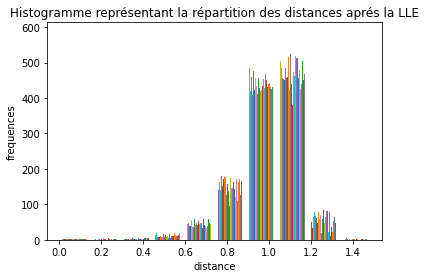

In [43]:
import sklearn
import matplotlib.pyplot as plt

plt.hist(sklearn.metrics.pairwise.cosine_distances(a))
plt.ylabel('frequences')
plt.xlabel('distance')
plt.title('Histogramme représentant la répartition des distances aprés la LLE')


Text(0.5, 1.0, 'Histogramme représentant la répartition des distances avant la LLE')

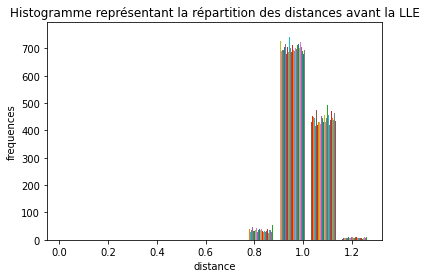

In [44]:
plt.hist(sklearn.metrics.pairwise.cosine_distances(np.array(embedding_corpus)))
plt.ylabel('frequences')
plt.xlabel('distance')
plt.title('Histogramme représentant la répartition des distances avant la LLE')

Text(0.5, 1.0, 'Histogramme représentant la répartition des distances aprés la LLE')

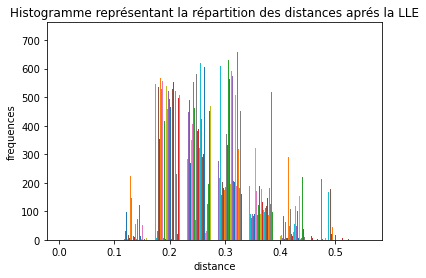

In [46]:
plt.hist(sklearn.metrics.pairwise.euclidean_distances(a))
plt.ylabel('frequences')
plt.xlabel('distance')
plt.title('Histogramme représentant la répartition des distances aprés la LLE')

Text(0.5, 1.0, 'Histogramme représentant la répartition des distances avant la LLE')

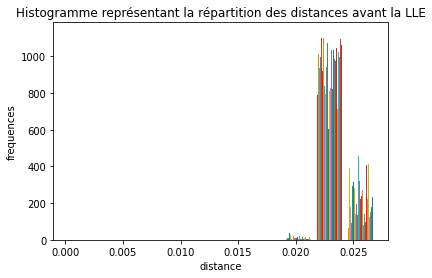

In [47]:
plt.hist(sklearn.metrics.pairwise.euclidean_distances(np.array(embedding_corpus)))
plt.ylabel('frequences')
plt.xlabel('distance')
plt.title('Histogramme représentant la répartition des distances avant la LLE')

Version de nos librairy

In [91]:
print("nltk")
print(nltk.__version__)
print("numpy")
print(np.__version__)
print("gensim")
print(gensim.__version__)
print("re")
print(re.__version__)
print("urllib.request")
print(urllib.request.__version__)
print("pandas")
print(pd.__version__)
print("praw")
print(praw.__version__)
print("xmltodict")
print(xmltodict.__version__)
print("keras")
print(keras.__version__)
print("sklearn")
print(sklearn.__version__)
print("matplotlib") 
print(matplotlib.__version__)


nltk
3.2.5
numpy
1.19.5
gensim
3.6.0
re
2.2.1
urllib.request
3.7
pandas
1.1.5
praw
7.5.0
xmltodict
0.12.0
keras
2.7.0
sklearn
1.0.1
matplotlib
3.2.2


In [74]:
pip list 

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl